# Stock Price Forecasting: Prophet Model (Part 4)

Author: **Marcin Sikorski**<br>
Date: March, 2024

This notebook demonstrates price forecasting with Facebook's Prophet model.

**Notebook Content:**
1. Importing Dataset
2. Developing Prophet Model
3. Model Evaluation

### 1. Importing Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# set plotting style
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 9

# import dataset
df = pd.read_csv('mtd_prices.csv')
df.fillna(0, inplace=True)

df['date'] = pd.to_datetime(df['date'])

# Prophet requires column names to be 'ds' & 'y'
df.rename(columns={'date': 'ds', 'close': 'y'}, inplace=True)

df.sample(5)

,ds,high,low,unix,cum_change,open,cma_7,sma_7_up,sma_7,sma_7_low,ema_14,b_ma,bu,bl,year,atr,y
3518,2007-07-03,96.769997,96.000000,1183420800,4.546555,96.000000,43.413328,96.480970,95.724288,94.967606,95.851994,96.104333,98.858762,93.349904,2007,1.452268,96.559998
2428,2004-07-08,47.389999,46.950001,1089244800,2.547552,47.040001,35.241589,48.568663,47.427858,46.287053,47.925339,48.700417,50.536239,46.864595,2004,0.781767,47.020000
8014,2019-10-24,690.119995,678.390015,1571875200,43.422463,686.909973,182.041685,690.082681,684.465707,678.848733,682.916390,680.211161,697.263386,663.158936,2019,14.883363,686.739990
2447,2004-07-27,40.660000,39.759998,1090886400,2.572808,40.650002,35.314730,46.247097,42.017143,37.787188,43.320299,44.811500,49.844781,39.778219,2004,1.323188,40.500000
784,2000-01-07,35.750000,34.562500,947203200,0.561271,34.562500,24.024960,37.668875,35.383929,33.098982,35.678218,35.931424,37.929630,33.933217,2000,1.223934,35.625000


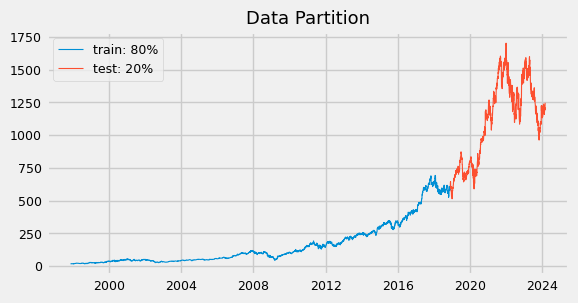

In [2]:
# split data by 80% training and 20% testing
cut_off = int(len(df) * 0.8)

train = df[:cut_off]
test = df[cut_off:]

# plot train / test split
plt.figure(figsize=(6, 3))

plt.plot(train['ds'], train['y'], label='train: 80%')
plt.plot(test['ds'], test['y'], label='test: 20%') 
plt.title('Data Partition')
plt.legend()

plt.show()

### 2. Developing Prophet Model

In [3]:
def exogenous_list():
    '''
    Returns list of exogenous variables.
    '''
    reg_list = train.columns.tolist()
    reg_list.remove('ds')
    reg_list.remove('y')
    
    return reg_list

regressors = exogenous_list()
regressors

['high',
 'low',
 'unix',
 'cum_change',
 'open',
 'cma_7',
 'sma_7_up',
 'sma_7',
 'sma_7_low',
 'ema_14',
 'b_ma',
 'bu',
 'bl',
 'year',
 'atr']

In [4]:
from sklearn.model_selection import ParameterGrid
from prophet import Prophet

# parameters to tune
grid = ParameterGrid(
    {
    'seasonality_mode': ('multiplicative', 'additive'),
    'n_changepoints': (10, 25, 30)
    }
)

count = 0
for i in grid:
    count = count + 1

print('Excepted fits:', count)

def hyperparameter_tuning():
    '''
    Returns hyperparameter tuning results in dataframe.
    '''
    rmse_list = []
    param_list = []
    
    count = 0
    for param in grid:
        count = count + 1
        
        train_model = Prophet(
            weekly_seasonality='auto',
            daily_seasonality ='auto',
            yearly_seasonality = 'auto',
            holidays=None,
            interval_width=0.95,
            changepoint_range=0.8,
            n_changepoints = param['n_changepoints'],
            seasonality_mode = param['seasonality_mode']
        )
        
        # add exogenous variables
        for i in regressors:
            train_model.add_regressor(i, prior_scale=None, standardize='auto')
        
        train_model.fit(train)
        
        # date dataframe - placeholder object
        train_forecast = train_model.make_future_dataframe(periods=len(test), freq='D', include_history=True)
        
        # add exogenous variables to 'future' dataframe
        for i in regressors:
            train_forecast[i] = pd.concat([train[i], test[i]])
        
        # get forecasted prices
        forecasts = train_model.predict(train_forecast)
        
        true = test['y']
        pred = forecasts['yhat'].iloc[-len(test):]
        
        rmse = np.sum(((pred - true)**2) / len(pred))**0.5
        
        # add to lists
        rmse_list.append(rmse)
        param_list.append(param)
        
        print('{}. {}'.format(count, param))
        print('RMSE: {:.4f}\n'.format(rmse))
    
    # dataframe for grid search scores
    model_parameters = pd.DataFrame(columns=['rmse', 'parameters'])
    model_parameters['rmse'] = rmse_list
    model_parameters['parameters'] = param_list
    
    return model_parameters
    
df_params = hyperparameter_tuning()

Excepted fits: 6


15:23:16 - cmdstanpy - INFO - Chain [1] start processing
15:23:31 - cmdstanpy - INFO - Chain [1] done processing


1. {'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}
RMSE: 8.2490



15:23:37 - cmdstanpy - INFO - Chain [1] start processing
15:23:41 - cmdstanpy - INFO - Chain [1] done processing


2. {'n_changepoints': 10, 'seasonality_mode': 'additive'}
RMSE: 8.9070



15:23:48 - cmdstanpy - INFO - Chain [1] start processing
15:24:09 - cmdstanpy - INFO - Chain [1] done processing


3. {'n_changepoints': 25, 'seasonality_mode': 'multiplicative'}
RMSE: 8.1875



15:24:15 - cmdstanpy - INFO - Chain [1] start processing
15:24:23 - cmdstanpy - INFO - Chain [1] done processing


4. {'n_changepoints': 25, 'seasonality_mode': 'additive'}
RMSE: 8.7956



15:24:29 - cmdstanpy - INFO - Chain [1] start processing
15:24:48 - cmdstanpy - INFO - Chain [1] done processing


5. {'n_changepoints': 30, 'seasonality_mode': 'multiplicative'}
RMSE: 8.0641



15:24:53 - cmdstanpy - INFO - Chain [1] start processing
15:25:03 - cmdstanpy - INFO - Chain [1] done processing


6. {'n_changepoints': 30, 'seasonality_mode': 'additive'}
RMSE: 8.7860



In [5]:
# display results
with pd.option_context('display.max_colwidth', None):
    display(df_params.sort_values(by=['rmse']))

,rmse,parameters
4,8.064149,"{'n_changepoints': 30, 'seasonality_mode': 'multiplicative'}"
2,8.187498,"{'n_changepoints': 25, 'seasonality_mode': 'multiplicative'}"
0,8.248979,"{'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}"
5,8.786014,"{'n_changepoints': 30, 'seasonality_mode': 'additive'}"
3,8.795604,"{'n_changepoints': 25, 'seasonality_mode': 'additive'}"
1,8.906994,"{'n_changepoints': 10, 'seasonality_mode': 'additive'}"


In [6]:
model = Prophet(
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    changepoints=None,
    holidays=None,
    interval_width=0.95,
    changepoint_range=0.8,
    n_changepoints=30,
    seasonality_mode='multiplicative'
)

# add exogenous variables
for i in regressors:
    model.add_regressor(i, prior_scale=None, standardize='auto')
    
model.fit(train)

# prepair data for forecasts
# date dataframe - placeholder object
future = model.make_future_dataframe(periods=len(test), freq='D', include_history=True)

# add exogenous variables to 'future' dataframe
for i in regressors:
    future[i] = pd.concat([train[i], test[i]])

# parameters & coefficients
#model.params

15:26:17 - cmdstanpy - INFO - Chain [1] start processing
15:26:38 - cmdstanpy - INFO - Chain [1] done processing


### 3. Model Evaluation

In [7]:
# get forecasted prices
forecasts = model.predict(df=future)

# display trues vs. forecasts
pd.concat([forecasts[['ds', 'yhat']], df['y'], forecasts[['yhat_lower', 'yhat_upper']]], axis=1).head(10)

,ds,yhat,y,yhat_lower,yhat_upper
0,1997-11-14,16.702079,14.875000,14.455013,18.746769
1,1997-11-15,16.084642,15.000000,13.880274,18.335587
2,1997-11-16,16.125076,15.125000,13.923158,18.341172
3,1997-11-17,16.173019,15.250000,14.079879,18.550031
4,1997-11-18,16.184724,15.000000,14.114698,18.203704
5,1997-11-19,16.341424,15.625000,13.874683,18.387884
6,1997-11-20,17.802233,16.375000,15.680926,19.926210
7,1997-11-21,18.475525,17.125000,16.317384,20.649627
8,1997-11-22,18.462652,17.083333,16.195372,20.682342
9,1997-11-23,18.441166,17.041667,16.233540,20.665014


Prophet has a built-in function dedicated for cross-validation. We will implement it to return the mean RMSE score of all folds.

In [8]:
from prophet.diagnostics import cross_validation, performance_metrics

def cross_val_prophet(k=6):
    '''
    Returns k-fold cross-validation score (RMSE).
    '''
    # initial - minimum training period to start with
    # period - time gap between cut-off dates
    # horizon - test period of each fold
    
    initial = str(len(df) / (k + 1)) + ' days'
    df_cv = cross_validation(model, initial=initial, period=initial, horizon='30 days', disable_tqdm=False)
    
    # performance metrics
    df_performance = performance_metrics(df=df_cv, metrics=['rmse', 'mae', 'mape'])
    
    return df_performance['rmse'].mean()

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

true = test['y']
pred = forecasts['yhat'].iloc[-len(test):]

rmse = np.sqrt(mean_squared_error(true, pred))
cv_rmse = cross_val_prophet()
r2 = r2_score(true, pred)
mae = mean_absolute_error(true, pred)
mape = mean_absolute_percentage_error(true, pred)

print('Testing performance:')
print('--------------------')
print('RMSE: {:.4f}'.format(rmse))
print('6-fold CV: {:.4f}'.format(cv_rmse))
print('R2: {:.4f}'.format(r2))
print('MAE: {:.4f}'.format(mae))
print('MAPE: {:.4f}%'.format(mape))

  0%|          | 0/5 [00:00<?, ?it/s]

15:26:51 - cmdstanpy - INFO - Chain [1] start processing
15:26:53 - cmdstanpy - INFO - Chain [1] done processing
15:26:54 - cmdstanpy - INFO - Chain [1] start processing
15:26:58 - cmdstanpy - INFO - Chain [1] done processing
15:27:00 - cmdstanpy - INFO - Chain [1] start processing
15:27:17 - cmdstanpy - INFO - Chain [1] done processing
15:27:18 - cmdstanpy - INFO - Chain [1] start processing
15:27:45 - cmdstanpy - INFO - Chain [1] done processing
15:27:47 - cmdstanpy - INFO - Chain [1] start processing
15:28:03 - cmdstanpy - INFO - Chain [1] done processing


Testing performance:
--------------------
RMSE: 8.0641
6-fold CV: 1.8883
R2: 0.9993
MAE: 5.8148
MAPE: 0.0052%


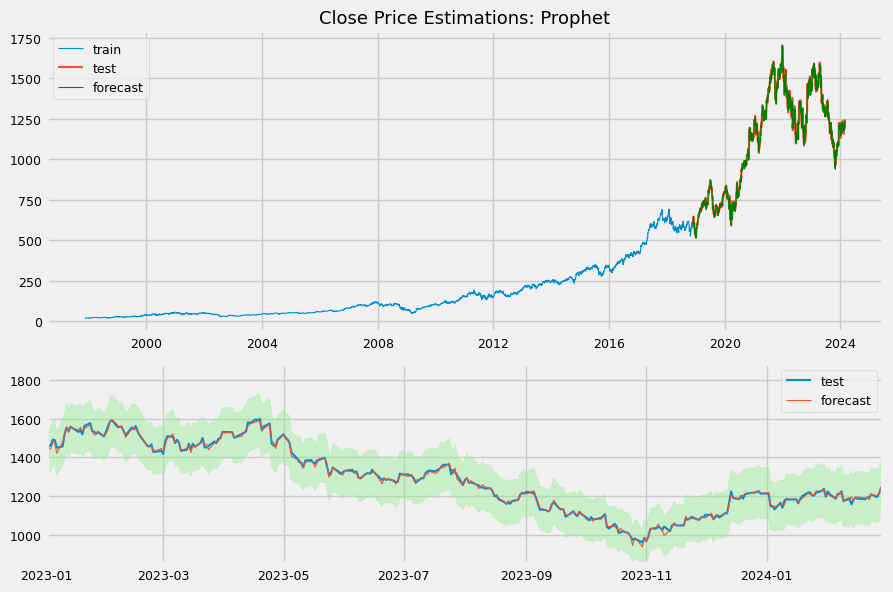

In [10]:
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(9, 6), tight_layout=True, gridspec_kw={'height_ratios': [1.5, 1]})

axes[0].plot(train['ds'], train['y'], label='train')
axes[0].plot(test['ds'], test['y'], linewidth=1.5, label='test')
axes[0].plot(forecasts['ds'].iloc[-len(test):], forecasts['yhat'].iloc[-len(test):], color='green', label='forecast')
axes[0].set_title('Close Price Estimations: Prophet')
axes[0].legend()

# zoomed view
axes[1].plot(test['ds'], test['y'], linewidth=1.5, label='test')
axes[1].plot(forecasts['ds'].iloc[-len(test):], forecasts['yhat'].iloc[-len(test):], label='forecast')
axes[1].fill_between(forecasts['ds'], forecasts['yhat_lower'], forecasts['yhat_upper'], alpha=0.4, color='lightgreen')
axes[1].set_xlim(pd.Timestamp('2023-01-01'), test['ds'].iloc[-1])
axes[1].set_ylim(850)
axes[1].legend()

plt.show()

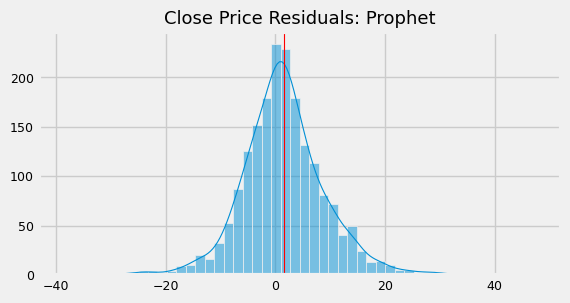

In [11]:
from seaborn import histplot

resid = test['y'] - forecasts['yhat'].iloc[-len(test):]

# plot residuals
plt.figure(figsize=(6, 3))

histplot(x=resid, kde=True, bins=50)
plt.axvline(x=resid.mean(), color='red') # plot mean value
plt.title('Close Price Residuals: Prophet')
plt.xlabel(None)
plt.ylabel(None)

plt.show()

The forecasted trend line has a good fit. The residuals are balanced with a Gaussian distribution. The overall accuracy of the Prophet model is very good.

The last plot will illustrate the detected changepoints in our model - changes in the time series trend trajectories, and their rates. The changepoints are searched by default within 80% of the time series.

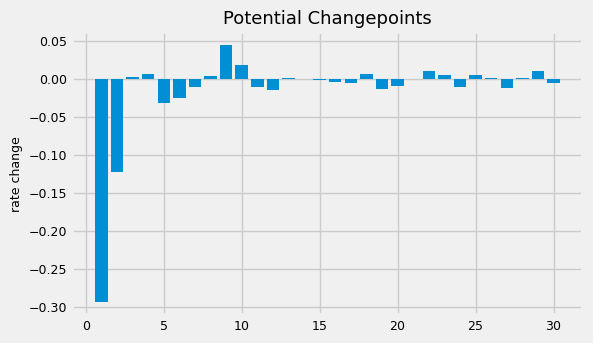

In [12]:
deltas = model.params['delta'].mean(0)

# plot potential changepoints in trend
plt.figure(figsize=(6, 3.5), tight_layout=True)

plt.bar(x=range(1, len(deltas) + 1), height=deltas)
plt.title('Potential Changepoints')
plt.ylabel('rate change')
plt.show()

# display dates for detected changes
#model.changepoints

The rates are low which suggests that the time series trend is rather constant and not dynamic.

The next and last notebook will present price predicting with `scikit-learn` regressors.